# Однослойный перцептрон
Демонстрация с бесконечностью

In [1]:
import numpy as np

# Функция активации нейрона в выходном слое и ее производная
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def dsigmoid(y):
    return y * (1 - y)

# Функция активации нейронов во внутреннем слое и ее производная
def tanh(x):
    return np.tanh(x)
def dtanh(y):
    return 1 - y * y

In [2]:
from matplotlib import pyplot as plt

class Perceptron:
    def __init__(self, X, Y, hidden_size):

        # Пусть n - количество признаков, m - количество объектов, k - размерность результирующего вектора
        # Тогда X = X(n * m), Y = Y(k, m)
        assert X.shape[1] == Y.shape[1]
        self.X = X
        self.Y = Y
        self.m = X.shape[1]

        # Инициализируем матрицы весов рандомными числами (W1 - для скрытого слоя, W2 - для выходного, в нем всего 1 нейрон)
        self.W1 = np.random.randn(hidden_size, X.shape[0])
        self.W2 = np.random.randn(Y.shape[0], hidden_size)

        # Заполняем свободные векторы нулями
        self.b1 = np.zeros((hidden_size, 1))
        self.b2 = np.zeros((Y.shape[0], 1))

        # Здесь будем накапливать значения функции потерь на каждой итерации
        self.ce_loss = []
        self.mse_loss = []

    def learn(self, iter_num, learning_rate):

        # Итерируемся необходимое количество раз
        for i in range(iter_num):

            # Расчет взыешенных сумм каждого из нейронов, применение функций активации
            # Для того, чтобы заменить функции активации, необходимо заменить функцию при вычислении А1/А2
            Z1 = np.dot(self.W1, self.X) + self.b1                                     # (hidden_size, X.shape[1])
            A1 = tanh(Z1)
            Z2 = np.dot(self.W2, A1) + self.b2                                         # (Y.shape[0], X.shape[1] = Y.shape[1])
            A2 = sigmoid(Z2)

            # Среднеквадратичная (MSE) функция потерь
            mse_loss = np.sum((A2 - self.Y) ** 2) / self.m

            # Cross entropy функция потерь
            eps = 1e-8
            logprobs = self.Y * np.log(A2 + eps) + (1 - self.Y) * np.log(1 - A2 + eps)
            ce_loss = (-1 / self.m) * np.sum(logprobs)

            # Запоминание значения функции потерь и печать на каждой 1000-й итерации
            self.mse_loss.append(mse_loss)
            self.ce_loss.append(ce_loss)
            if i % 1000 == 0: print(f"MSE loss: {mse_loss}, CE loss: {ce_loss}")

            # Алгоритм обратного распространения ошибки
            # Производные высчитываются по правилу производной для сложной функции
            # Оптимизируется среднеквадратичная функция потерь
            # Для оптимизации cross entropy необходимо заменить производную функции потерь по A2 - self.Y
            # Для этого необходимо найти dError/dW
            # При замене функций активации необходимо также заменить соответствующую ей производную
            dA2 = (A2 - self.Y) * dsigmoid(A2)        # dLoss/dA * dSig/dZ2            # (Y.shape[0], Y.shape[1] = X.shape[1])
            dW2 = np.dot(dA2, A1.T)                   # dZ2/dW2                        # (Y.shape[0], hidden_size)
            db2 = np.sum(dA2, axis=1, keepdims=True)                                   # (Y.shape[0], 1)
            dA1 = np.dot(self.W2.T, dA2) * dtanh(A1)  # dA2 * dZ2/dA1 * dTanh/dZ       # (hidden_size, Y.shape[1] = X.shape[1])
            dW1 = np.dot(dA1, self.X.T)               # dZ1/dW                         # (hidden_size, X.shape[0])
            db1 = np.sum(dA1, axis=1, keepdims=True)                                   # (hidden_size, 1)

            # Обновление весов методом градиентного спуска
            self.W2 -= learning_rate * dW2
            self.b2 -= learning_rate * db2
            self.W1 -= learning_rate * dW1
            self.b1 -= learning_rate * db1

    def predict(self, X):
        # Используем найденные матрицы весов
        A1 = tanh(np.dot(self.W1, X) + self.b1)
        A2 = sigmoid(np.dot(self.W2, A1) + self.b2)
        return (A2[0] > 0.5).astype(int)

    def plot(self):
        plt.figure(figsize=(10,3))
        plt.subplot(1, 2, 1)
        plt.ylabel('MSE loss')
        plt.xlabel('Iterations')
        plt.plot(self.mse_loss)
        plt.subplot(1, 2, 2)
        plt.ylabel('CE loss')
        plt.xlabel('Iterations')
        plt.plot(self.ce_loss)

## Разделение бесконечности

In [3]:
def create_infinity(m, noise=0.1):
    D = 2
    N = m//2 # количество точек для каждого класса
    X = np.zeros((m, D))
    Y = np.zeros((m, 1), dtype='uint8')

    # Class 0 (top part))
    t = np. linspace(0, 1, N)
    x_top = t*2 - 1 # scale to [-1, 1]
    y_top = np.sin(2*np.pi*t) + np.random.randn(N)*noise

    X[0:N] = np.c_[x_top, y_top]
    Y[0:N] = 0

    # Class 1 (bottom part)
    x_bottom = t*2 - 1  # scale to [-1, 1]
    y_bottom = -np.sin(2*np.pi*t) + np.random.randn(N)*noise

    X[N:m] = np.c_[x_bottom, y_bottom]
    Y[N:m] = 1

    return X.T, Y.T

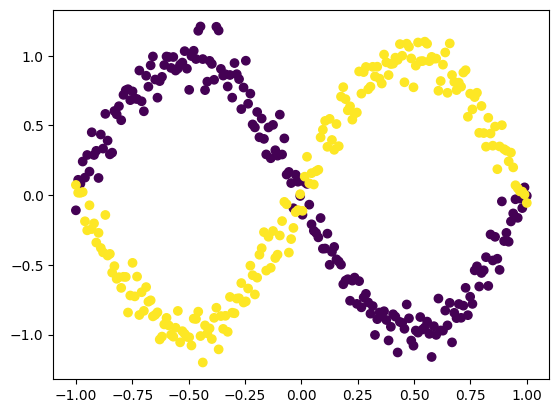

In [4]:
X, Y = create_infinity(400)
plt.scatter(X[0, :], X[1, :], c=Y)

In [5]:
# Строим разделяющую  прямую, показывающую результат обучения нейросети
def plot_division(perceptron):
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = perceptron.predict(np.c_[xx.ravel(), yy.ravel()].T)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=Y, cmap=plt.cm.Spectral);

### Один нейрон

In [6]:
perceptron = Perceptron(X, Y, 1)
perceptron.learn(10000, 0.01)

MSE loss: 0.28619809943883145, CE loss: 0.7729321243919087
MSE loss: 0.19679364876296773, CE loss: 0.5588418233522596
MSE loss: 0.19576929645756797, CE loss: 0.5543428904752343
MSE loss: 0.19529887265586696, CE loss: 0.5523235665008729
MSE loss: 0.19500274778982926, CE loss: 0.5510946456214633
MSE loss: 0.1947904095989198, CE loss: 0.5502386052217904
MSE loss: 0.19462682713169535, CE loss: 0.5495945519785953
MSE loss: 0.1944948740390079, CE loss: 0.5490851663443467
MSE loss: 0.1943849382002207, CE loss: 0.5486678967430528
MSE loss: 0.19429111029051616, CE loss: 0.5483170589980302


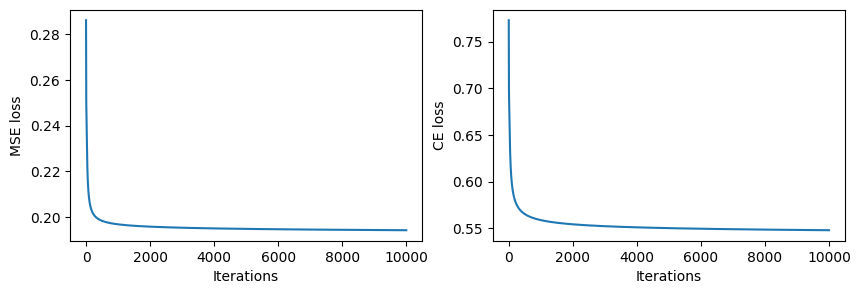

In [7]:
perceptron.plot()

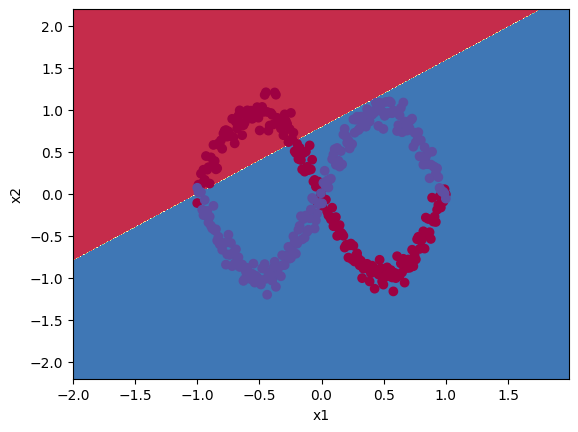

In [8]:
# Строим разделяющую  прямую, показывающую результат обучения нейросети
plot_division(perceptron)

### Четыре нейрона

In [28]:
perceptron = Perceptron(X, Y, 4)
perceptron.learn(10000, 0.01)

MSE loss: 0.30036563099306834, CE loss: 0.8174440681501843
MSE loss: 0.028377634413466586, CE loss: 0.10356625268946591
MSE loss: 0.025402470703084056, CE loss: 0.09030726283964624
MSE loss: 0.023969901152421716, CE loss: 0.08455691636158504
MSE loss: 0.023005041852407388, CE loss: 0.08090952326028543
MSE loss: 0.0223024330369337, CE loss: 0.07821839027925677
MSE loss: 0.02176669014152191, CE loss: 0.07610076318608516
MSE loss: 0.021342266496102266, CE loss: 0.07437666219904404
MSE loss: 0.020994970618587936, CE loss: 0.07293887521696946
MSE loss: 0.0207028454248362, CE loss: 0.0717169486227547


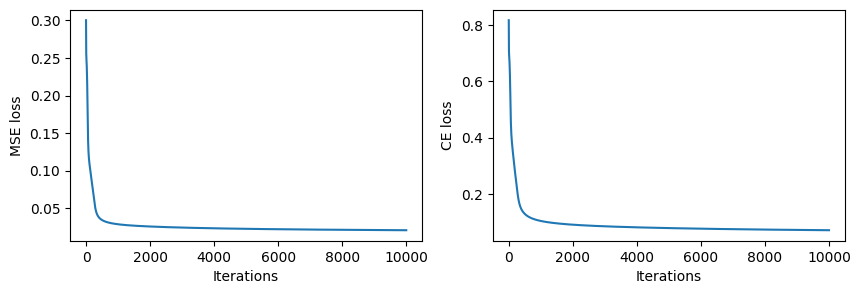

In [29]:
perceptron.plot()

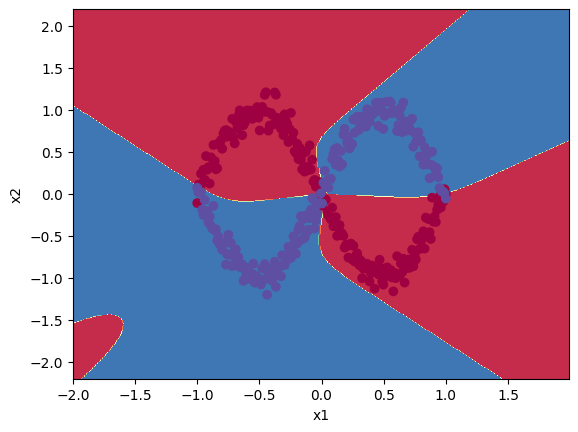

In [30]:
plot_division(perceptron)

### много нейронов - стало ли лучше?

In [37]:
perceptron = Perceptron(X, Y, 4)
perceptron.learn(10000, 0.01)

MSE loss: 0.3499577554981763, CE loss: 0.9843836448069193
MSE loss: 0.028358641515914818, CE loss: 0.10136911713154334
MSE loss: 0.025544843754925054, CE loss: 0.08907862721859988
MSE loss: 0.02413371400576664, CE loss: 0.08369556052674454
MSE loss: 0.02313148528428483, CE loss: 0.08033632945287675
MSE loss: 0.022373318592917125, CE loss: 0.07781348575923318
MSE loss: 0.021803458316109, CE loss: 0.07572700838311903
MSE loss: 0.021359830200721817, CE loss: 0.07398272234638553
MSE loss: 0.02100004229321003, CE loss: 0.07251988858124563
MSE loss: 0.020698489432468686, CE loss: 0.07128135787198062


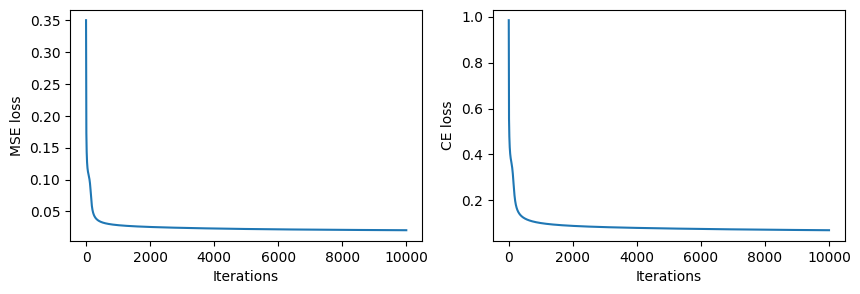

In [38]:
perceptron.plot()

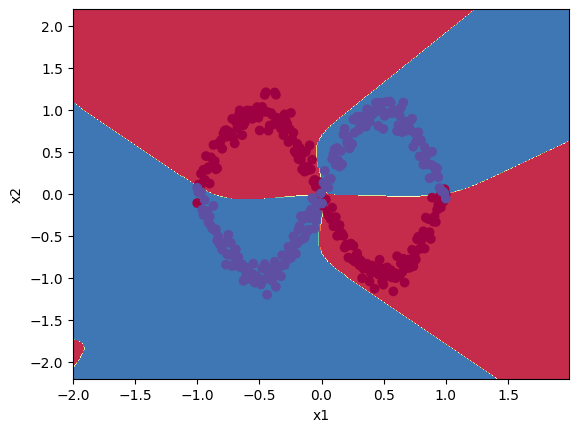

In [39]:
plot_division(perceptron)

почти хорошо, но еще чуть-чуть надо

In [54]:
perceptron = Perceptron(X, Y, 5)
perceptron.learn(10000, 0.01)

MSE loss: 0.290155927881874, CE loss: 0.7840631536834144
MSE loss: 0.027814528415527645, CE loss: 0.10211442335170037
MSE loss: 0.025322492701027408, CE loss: 0.08998465325178157
MSE loss: 0.024177447076441882, CE loss: 0.08437885325742465
MSE loss: 0.023449659177855943, CE loss: 0.0808778499896881
MSE loss: 0.022925458757428414, CE loss: 0.07837869545390178
MSE loss: 0.022522562663219142, CE loss: 0.0764607728481309
MSE loss: 0.02219808510514833, CE loss: 0.07491705758276705
MSE loss: 0.021925952703202654, CE loss: 0.07362826378604748
MSE loss: 0.021690041049185246, CE loss: 0.07252268696905541


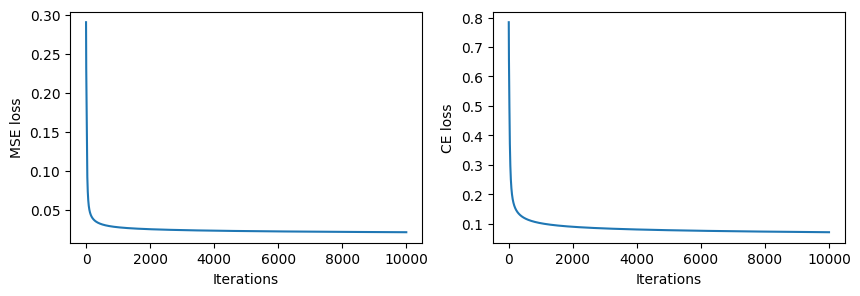

In [55]:
perceptron.plot()

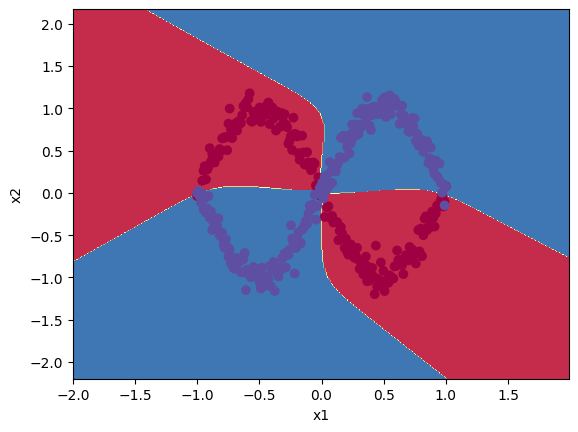

In [56]:
plot_division(perceptron)

вот пять уже хорошо, выше всё супер

In [57]:
perceptron = Perceptron(X, Y, 6)
perceptron.learn(10000, 0.01)

MSE loss: 0.29638346349567224, CE loss: 0.8029832136918895
MSE loss: 0.02718682554751509, CE loss: 0.09868136296285779
MSE loss: 0.02424525281581272, CE loss: 0.0855960097750159
MSE loss: 0.022924954261349106, CE loss: 0.0794617377141014
MSE loss: 0.022019055129727842, CE loss: 0.07527666315996236
MSE loss: 0.021428991532342737, CE loss: 0.07234739394800867
MSE loss: 0.02102807763202704, CE loss: 0.07019077350948848
MSE loss: 0.0207350973137384, CE loss: 0.06858838356973328
MSE loss: 0.020509349026021372, CE loss: 0.06735774110322784
MSE loss: 0.020329740453851736, CE loss: 0.06637734779113333


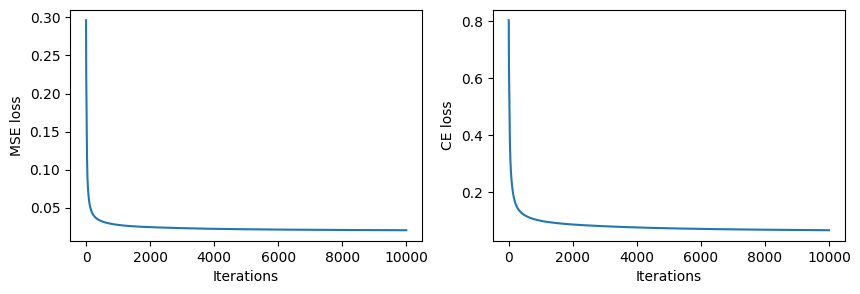

In [58]:
perceptron.plot()

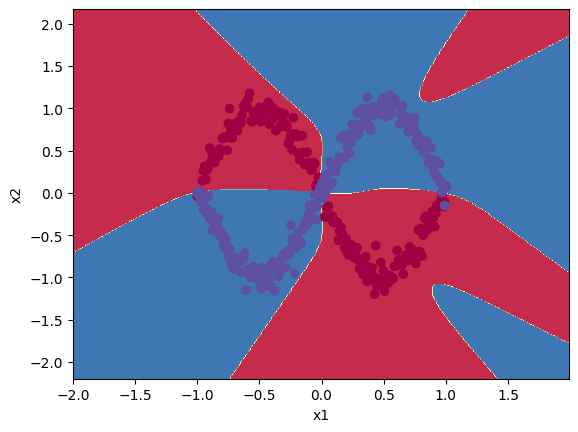

In [59]:
plot_division(perceptron)

плохо, есть огрызки переобучение

In [66]:
perceptron = Perceptron(X, Y, 10)
perceptron.learn(10000, 0.01)

MSE loss: 0.34872233873949954, CE loss: 1.0487616757559
MSE loss: 0.02621590910831995, CE loss: 0.09426109614876058
MSE loss: 0.023582915072481246, CE loss: 0.0819778375706165
MSE loss: 0.022258955159934396, CE loss: 0.07593235529172784
MSE loss: 0.02144529097724976, CE loss: 0.07210764833017481
MSE loss: 0.02092251680220287, CE loss: 0.06952337793786471
MSE loss: 0.020563791591959715, CE loss: 0.06767765950911521
MSE loss: 0.020300209134771947, CE loss: 0.06628990647139413
MSE loss: 0.02009508875532622, CE loss: 0.0652011857914287
MSE loss: 0.01992819309410439, CE loss: 0.06431893843845346


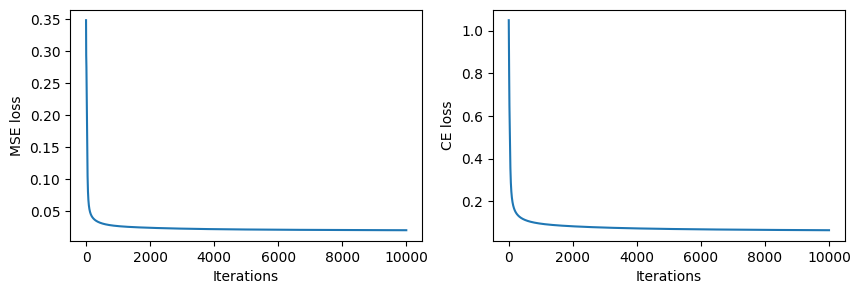

In [67]:
perceptron.plot()

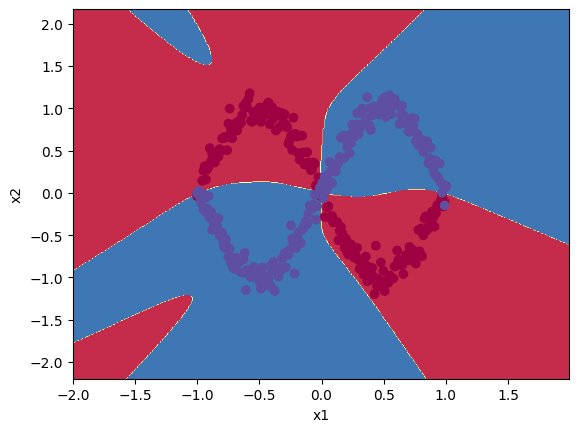

In [68]:
plot_division(perceptron)

Здесь тоже, так и далее будет

=======================

In [47]:
X, Y = create_infinity(400, noise=0.1)

m = X.shape[1]
perm = np.random.permutation(m)
train_size = int(0.7 * m)

train_idx = perm[:train_size]
test_idx  = perm[train_size:]

X_train, Y_train = X[:, train_idx], Y[:, train_idx]
X_test,  Y_test  = X[:, test_idx],  Y[:, test_idx]

In [48]:
def train_for_hidden_size(hidden_size, iter_num=10000, learning_rate=0.01):
    p = Perceptron(X_train, Y_train, hidden_size)
    p.learn(iter_num, learning_rate)
    Y_pred_train = p.predict(X_train)
    Y_pred_test  = p.predict(X_test)
    train_acc = np.mean(Y_pred_train == Y_train)
    test_acc  = np.mean(Y_pred_test == Y_test)
    return p, train_acc, test_acc

In [49]:
hidden_list = [1, 2, 3, 4, 5, 8, 10, 15, 20]
train_accs = []
test_accs  = []
perceptrons = {}
for h in hidden_list:
    print(f"\n=== hidden_size = {h} ===")
    p, tr_acc, te_acc = train_for_hidden_size(h, iter_num=8000, learning_rate=0.01)
    perceptrons[h] = p
    train_accs.append(tr_acc)
    test_accs.append(te_acc)
    print(f"train_acc = {tr_acc:.3f}, test_acc = {te_acc:.3f}")


=== hidden_size = 1 ===
MSE loss: 0.2577506814730711, CE loss: 0.7090733554633152
MSE loss: 0.1918308013346587, CE loss: 0.5481842725370887
MSE loss: 0.1900250303113332, CE loss: 0.5403407065339894
MSE loss: 0.18938420166097517, CE loss: 0.5374324919277887
MSE loss: 0.18903454924501695, CE loss: 0.535832346570242
MSE loss: 0.18880680850612178, CE loss: 0.5347930496706998
MSE loss: 0.18864303450542577, CE loss: 0.5340520486920236
MSE loss: 0.1885175672447563, CE loss: 0.5334910850165104
train_acc = 0.704, test_acc = 0.650

=== hidden_size = 2 ===
MSE loss: 0.260909626893137, CE loss: 0.7157058038801356
MSE loss: 0.10068011833485015, CE loss: 0.33436771464784876
MSE loss: 0.09911982870953613, CE loss: 0.3254796375444295
MSE loss: 0.09843288345634855, CE loss: 0.3221119800245652
MSE loss: 0.09801720206363643, CE loss: 0.32048593128797875
MSE loss: 0.09772274878325289, CE loss: 0.31964085158785416
MSE loss: 0.09749316241455587, CE loss: 0.3192055555157123
MSE loss: 0.09730273494234178, CE

Подтвердили еще раз что 5 хорошо, но уже с доп параметрами(пункт 2 задания)

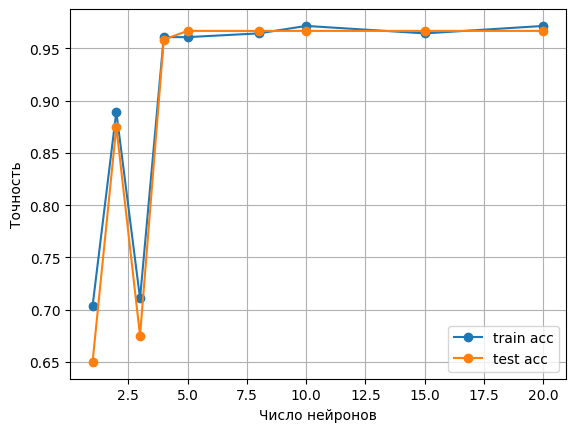

In [63]:
plt.plot(hidden_list, train_accs, 'o-', label='train acc')
plt.plot(hidden_list, test_accs, 'o-', label='test acc')
plt.xlabel('Число нейронов')
plt.ylabel('Точность')
plt.grid(True)
plt.legend()
plt.show()